In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.figsize'] = (20, 5)

In [2]:
def get_rms(data, n):
    new = np.zeros(data.shape)
    for channel in range(data.shape[1]):
        for current in range(data.shape[0]):
            suma = 0
            for window in range(current, current - n, -1):
                suma += data[window, channel] * data[window, channel]
            new[current, channel] = (np.sqrt((1/n)*suma) / 128) if channel != 8 else data[current, channel]
    #plt.figure()
    #plt.plot(data)
    #plt.figure()
    #plt.plot(new)
    return new

def peel_labels(data):
    return data[:,:8], data[:,8]

def get_values(seshes, skip_hibernation):
    big_matrix = np.zeros((0, 9))
    for sesh in seshes:
        for gesture in range(8):
            wei = sesh + "/" + str(gesture) + ".txt"
            print(wei)
            matrix = np.genfromtxt(wei, delimiter=",")
            rms = get_rms(matrix, 80)
            #plt.figure()
            #plt.plot(rms)
            if skip_hibernation:
                rms = rms[rms[:,8] != 0]
                rms[:,8] -= 1
            #plt.figure()
            #plt.plot(rms)
            big_matrix = np.concatenate((big_matrix, rms), axis = 0)
    return big_matrix

In [3]:
'''
#gotta go fast
skip_hibernation = False
readings = "../myo-readings-dataset/_readings/"
seshes = [x[0] for x in os.walk(readings)][1:]
print(*seshes, sep = "\n")
print("kekw")

start = 22

train_set, valid_set, test_set = get_values([seshes[start]], skip_hibernation), \
                                 get_values([seshes[start + 1]], skip_hibernation), \
                                 get_values([seshes[start + 2]], skip_hibernation)

train, train_labels = peel_labels(train_set)
valid, valid_labels = peel_labels(valid_set)
test, test_labels = peel_labels(test_set)
'''

'\n#gotta go fast\nskip_hibernation = False\nreadings = "../myo-readings-dataset/_readings/"\nseshes = [x[0] for x in os.walk(readings)][1:]\nprint(*seshes, sep = "\n")\nprint("kekw")\n\nstart = 22\n\ntrain_set, valid_set, test_set = get_values([seshes[start]], skip_hibernation),                                  get_values([seshes[start + 1]], skip_hibernation),                                  get_values([seshes[start + 2]], skip_hibernation)\n\ntrain, train_labels = peel_labels(train_set)\nvalid, valid_labels = peel_labels(valid_set)\ntest, test_labels = peel_labels(test_set)\n'

In [4]:
'''
#selected sessions
selection = [22, 23, 24, 25, 26, 27, 28, 29, 30]
skip_hibernation = False
readings = "../myo-readings-dataset/_readings/"
seshes = [x[0] for x in os.walk(readings)][1:]
seshes = [seshes[i] for i in selection]
np.random.shuffle(seshes)
print(*seshes, sep = "\n")
print("kekw")

siz = len(seshes)
split1 = int(0.6 * siz)
split2 = int(0.8 * siz)

train_set, valid_set, test_set = get_values(seshes[:split1], skip_hibernation), \
                                 get_values(seshes[split1:split2], skip_hibernation), \
                                 get_values(seshes[split2:], skip_hibernation)

train, train_labels = peel_labels(train_set)
valid, valid_labels = peel_labels(valid_set)
test, test_labels = peel_labels(test_set)
'''

'\n#selected sessions\nselection = [22, 23, 24, 25, 26, 27, 28, 29, 30]\nskip_hibernation = False\nreadings = "../myo-readings-dataset/_readings/"\nseshes = [x[0] for x in os.walk(readings)][1:]\nseshes = [seshes[i] for i in selection]\nnp.random.shuffle(seshes)\nprint(*seshes, sep = "\n")\nprint("kekw")\n\nsiz = len(seshes)\nsplit1 = int(0.6 * siz)\nsplit2 = int(0.8 * siz)\n\ntrain_set, valid_set, test_set = get_values(seshes[:split1], skip_hibernation),                                  get_values(seshes[split1:split2], skip_hibernation),                                  get_values(seshes[split2:], skip_hibernation)\n\ntrain, train_labels = peel_labels(train_set)\nvalid, valid_labels = peel_labels(valid_set)\ntest, test_labels = peel_labels(test_set)\n'

In [5]:

#all sessions
skip_hibernation = False
readings = "../myo-readings-dataset/_readings/"
seshes = [x[0] for x in os.walk(readings)][1:]
np.random.shuffle(seshes)
print(*seshes, sep = "\n")
print("kekw")

siz = len(seshes)
split1 = int(0.6 * siz)
split2 = int(0.8 * siz)
train_set, valid_set, test_set = get_values(seshes[:split1], skip_hibernation), \
                                 get_values(seshes[split1:split2], skip_hibernation), \
                                 get_values(seshes[split2:], skip_hibernation)

train, train_labels = peel_labels(train_set)
valid, valid_labels = peel_labels(valid_set)
test, test_labels = peel_labels(test_set)


../myo-readings-dataset/_readings/record_2
../myo-readings-dataset/_readings/session 1
../myo-readings-dataset/_readings/s2
../myo-readings-dataset/_readings/Sesh1
../myo-readings-dataset/_readings/record_3
../myo-readings-dataset/_readings/session_2_SH
../myo-readings-dataset/_readings/Seja 1
../myo-readings-dataset/_readings/session1
../myo-readings-dataset/_readings/Meritve seja 2
../myo-readings-dataset/_readings/myo_session2
../myo-readings-dataset/_readings/session3
../myo-readings-dataset/_readings/03
../myo-readings-dataset/_readings/Seja 3
../myo-readings-dataset/_readings/session_MK_1
../myo-readings-dataset/_readings/Seja 2
../myo-readings-dataset/_readings/Sesh2
../myo-readings-dataset/_readings/seja1_FS
../myo-readings-dataset/_readings/Session_4
../myo-readings-dataset/_readings/myo_session1
../myo-readings-dataset/_readings/myo_session3
../myo-readings-dataset/_readings/record_1
../myo-readings-dataset/_readings/seja-3
../myo-readings-dataset/_readings/Seja 02
../myo-rea

../myo-readings-dataset/_readings/session_MK_1/3.txt
../myo-readings-dataset/_readings/session_MK_1/4.txt
../myo-readings-dataset/_readings/session_MK_1/5.txt
../myo-readings-dataset/_readings/session_MK_1/6.txt
../myo-readings-dataset/_readings/session_MK_1/7.txt
../myo-readings-dataset/_readings/Seja 2/0.txt
../myo-readings-dataset/_readings/Seja 2/1.txt
../myo-readings-dataset/_readings/Seja 2/2.txt
../myo-readings-dataset/_readings/Seja 2/3.txt
../myo-readings-dataset/_readings/Seja 2/4.txt
../myo-readings-dataset/_readings/Seja 2/5.txt
../myo-readings-dataset/_readings/Seja 2/6.txt
../myo-readings-dataset/_readings/Seja 2/7.txt
../myo-readings-dataset/_readings/Sesh2/0.txt
../myo-readings-dataset/_readings/Sesh2/1.txt
../myo-readings-dataset/_readings/Sesh2/2.txt
../myo-readings-dataset/_readings/Sesh2/3.txt
../myo-readings-dataset/_readings/Sesh2/4.txt
../myo-readings-dataset/_readings/Sesh2/5.txt
../myo-readings-dataset/_readings/Sesh2/6.txt
../myo-readings-dataset/_readings/Ses

../myo-readings-dataset/_readings/sk_readings_1615725753_s01/0.txt
../myo-readings-dataset/_readings/sk_readings_1615725753_s01/1.txt
../myo-readings-dataset/_readings/sk_readings_1615725753_s01/2.txt
../myo-readings-dataset/_readings/sk_readings_1615725753_s01/3.txt
../myo-readings-dataset/_readings/sk_readings_1615725753_s01/4.txt
../myo-readings-dataset/_readings/sk_readings_1615725753_s01/5.txt
../myo-readings-dataset/_readings/sk_readings_1615725753_s01/6.txt
../myo-readings-dataset/_readings/sk_readings_1615725753_s01/7.txt
../myo-readings-dataset/_readings/session2/0.txt
../myo-readings-dataset/_readings/session2/1.txt
../myo-readings-dataset/_readings/session2/2.txt
../myo-readings-dataset/_readings/session2/3.txt
../myo-readings-dataset/_readings/session2/4.txt
../myo-readings-dataset/_readings/session2/5.txt
../myo-readings-dataset/_readings/session2/6.txt
../myo-readings-dataset/_readings/session2/7.txt
../myo-readings-dataset/_readings/AM-S2/0.txt
../myo-readings-dataset/_r

../myo-readings-dataset/_readings/Session_1/6.txt
../myo-readings-dataset/_readings/Session_1/7.txt
../myo-readings-dataset/_readings/sk_readings_1615834972_s03/0.txt
../myo-readings-dataset/_readings/sk_readings_1615834972_s03/1.txt
../myo-readings-dataset/_readings/sk_readings_1615834972_s03/2.txt
../myo-readings-dataset/_readings/sk_readings_1615834972_s03/3.txt
../myo-readings-dataset/_readings/sk_readings_1615834972_s03/4.txt
../myo-readings-dataset/_readings/sk_readings_1615834972_s03/5.txt
../myo-readings-dataset/_readings/sk_readings_1615834972_s03/6.txt
../myo-readings-dataset/_readings/sk_readings_1615834972_s03/7.txt
../myo-readings-dataset/_readings/mi-seja1/0.txt
../myo-readings-dataset/_readings/mi-seja1/1.txt
../myo-readings-dataset/_readings/mi-seja1/2.txt
../myo-readings-dataset/_readings/mi-seja1/3.txt
../myo-readings-dataset/_readings/mi-seja1/4.txt
../myo-readings-dataset/_readings/mi-seja1/5.txt
../myo-readings-dataset/_readings/mi-seja1/6.txt
../myo-readings-datas

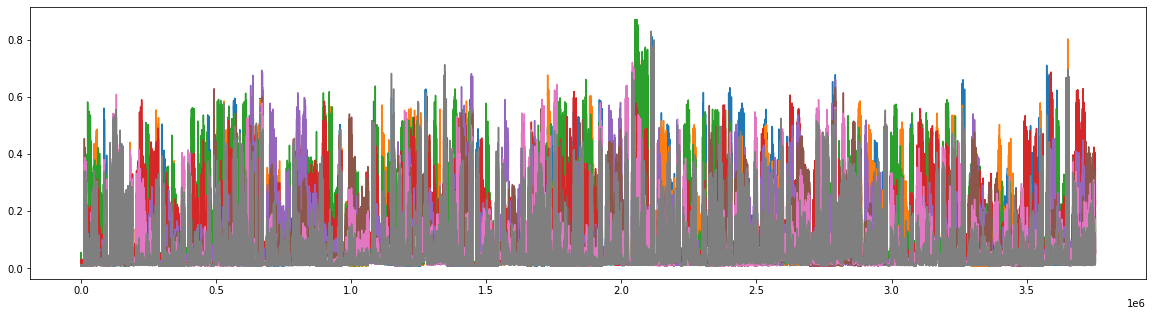

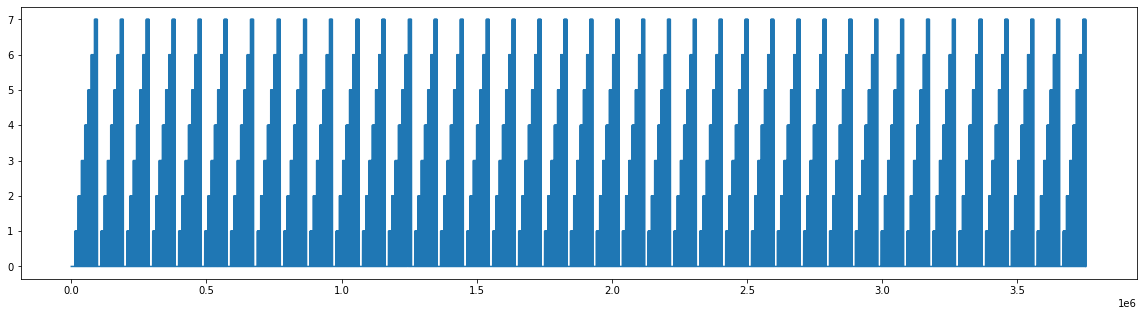

In [6]:
plt.figure()
plt.plot(train)
plt.figure()
plt.plot(train_labels)

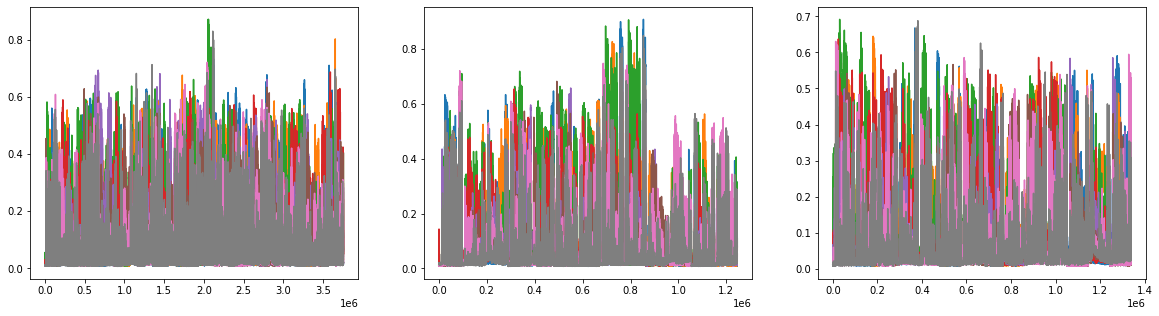

In [7]:
fig, ax = plt.subplots(1, 3)
ax[0].plot(train)
ax[1].plot(valid)
ax[2].plot(test)

In [8]:
model = keras.Sequential([
    keras.layers.Dense(200, activation = "relu", input_shape = (8,)),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(70, activation = "relu"),
    keras.layers.Dense(7 if skip_hibernation else 8, activation = "sigmoid")
])

opt = keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer = opt, loss = loss, metrics = ["accuracy"])

In [9]:
model_checkpoint = ModelCheckpoint("weights.h5", save_best_only = True, save_weights_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)
history = model.fit(train, train_labels, 
                    validation_data = (valid, valid_labels), 
                    epochs = 20, 
                    callbacks = [early_stopping, model_checkpoint])
model.load_weights("weights.h5")

Epoch 1/20
117316/117316 [==============================] - 113s 958us/step - loss: 0.6394 - accuracy: 0.8037 - val_loss: 1.7054 - val_accuracy: 0.6695
Epoch 2/20
117316/117316 [==============================] - 102s 865us/step - loss: 0.3829 - accuracy: 0.8870 - val_loss: 2.0452 - val_accuracy: 0.6604
Epoch 3/20
117316/117316 [==============================] - 101s 864us/step - loss: 0.3391 - accuracy: 0.8994 - val_loss: 2.1081 - val_accuracy: 0.6590
Epoch 4/20
117316/117316 [==============================] - 103s 878us/step - loss: 0.3155 - accuracy: 0.9059 - val_loss: 2.2817 - val_accuracy: 0.6626
Epoch 5/20
117316/117316 [==============================] - 102s 872us/step - loss: 0.3017 - accuracy: 0.9100 - val_loss: 2.4237 - val_accuracy: 0.6553
Epoch 6/20
117316/117316 [==============================] - 101s 863us/step - loss: 0.2909 - accuracy: 0.9132 - val_loss: 2.4437 - val_accuracy: 0.6556


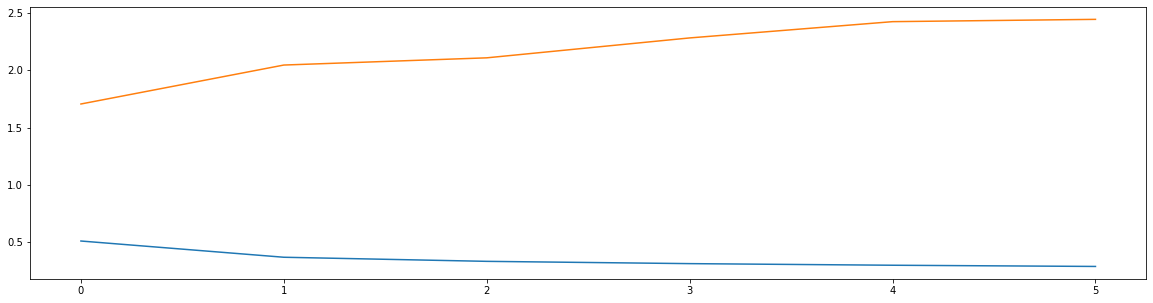

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

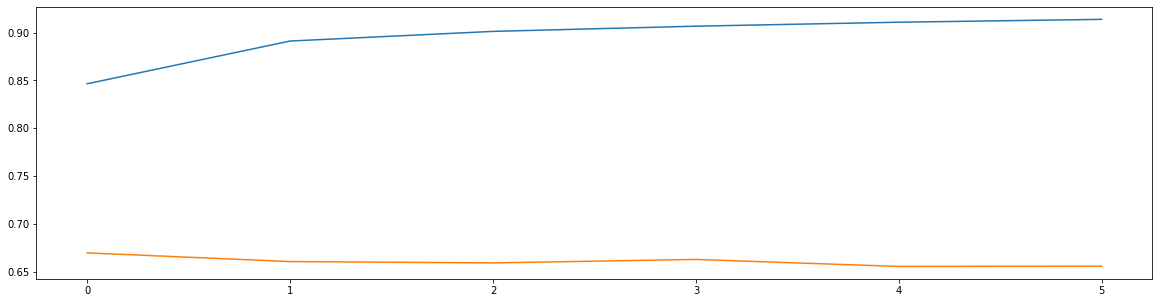

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [12]:
model.evaluate(test, test_labels)

41851/41851 [==============================] - 20s 477us/step - loss: 1.6260 - accuracy: 0.6226


[1.6260066032409668, 0.6225806474685669]

In [13]:
predictions = model.predict(test)

In [14]:
predicted_labels = np.argmax(predictions, axis=1)
conf = confusion_matrix(test_labels, predicted_labels, normalize="pred")
conf

array([[0.73021504, 0.11638005, 0.21296375, 0.329339  , 0.08012848,
        0.34327707, 0.27765849, 0.13662927],
       [0.03662735, 0.48453817, 0.01440551, 0.09533013, 0.1057815 ,
        0.02412366, 0.07134712, 0.03469153],
       [0.0289268 , 0.00869971, 0.41544193, 0.04614648, 0.03358717,
        0.12554973, 0.1639888 , 0.00131125],
       [0.03868498, 0.00498016, 0.12687047, 0.36260055, 0.04503106,
        0.19079032, 0.04903079, 0.02127143],
       [0.03683734, 0.13349934, 0.0578041 , 0.07539529, 0.55236961,
        0.03309727, 0.06275822, 0.0161883 ],
       [0.04096704, 0.04113299, 0.10321727, 0.06624699, 0.02263252,
        0.20608589, 0.23961557, 0.03585709],
       [0.0620233 , 0.12813011, 0.03736696, 0.01165166, 0.07213052,
        0.06309016, 0.11032297, 0.02080197],
       [0.02571814, 0.08263948, 0.03193   , 0.01328989, 0.08833915,
        0.0139859 , 0.02527803, 0.73324915]])

In [15]:
if skip_hibernation:
    legend = ["flexion", "extension", "radial deviation", "ulnar deviation", "pronation", "supination", "fist"]
else:
    legend = ["hibernation", "flexion", "extension", "radial deviation", "ulnar deviation", "pronation", "supination", "fist"]

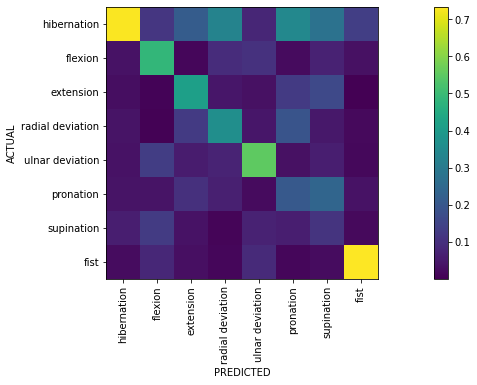

In [16]:
plt.imshow(conf)
plt.ylabel("ACTUAL")
plt.xlabel("PREDICTED")
plt.yticks(np.arange(len(legend)), legend)
plt.xticks(np.arange(len(legend)), legend, rotation='vertical')
plt.colorbar()

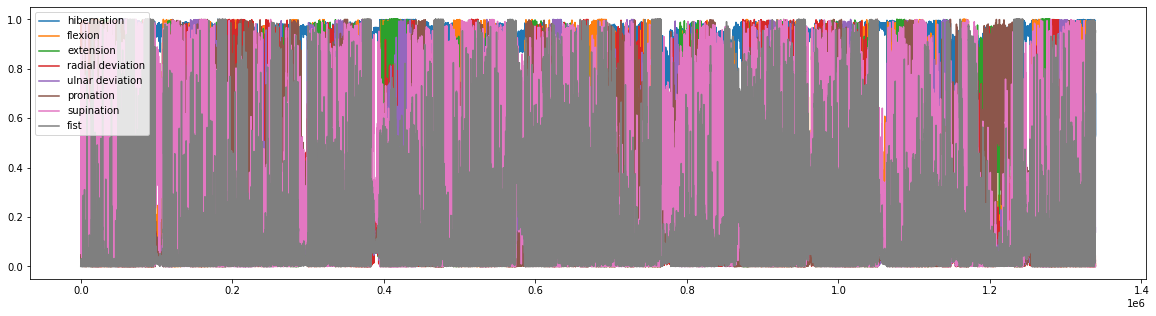

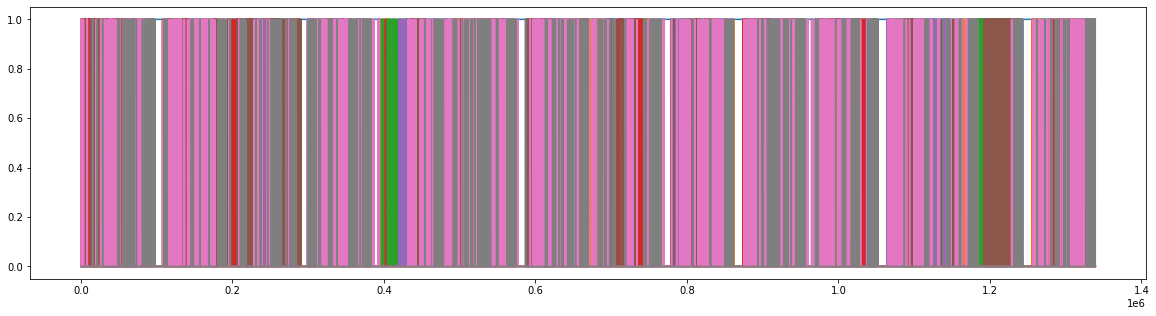

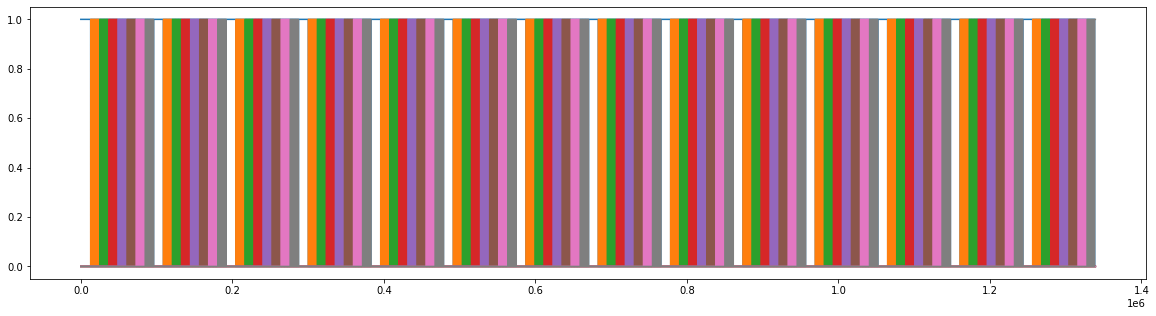

In [17]:
plt.figure()
plt.plot(predictions)
plt.legend(legend, loc = "upper left")

predicted_labels_onehot = keras.utils.to_categorical(predicted_labels, num_classes = 7 if skip_hibernation else 8)
test_labels_onehot = keras.utils.to_categorical(test_labels, num_classes = 7 if skip_hibernation else 8)

plt.figure()
plt.plot(predicted_labels_onehot)

plt.figure()
plt.plot(test_labels_onehot)

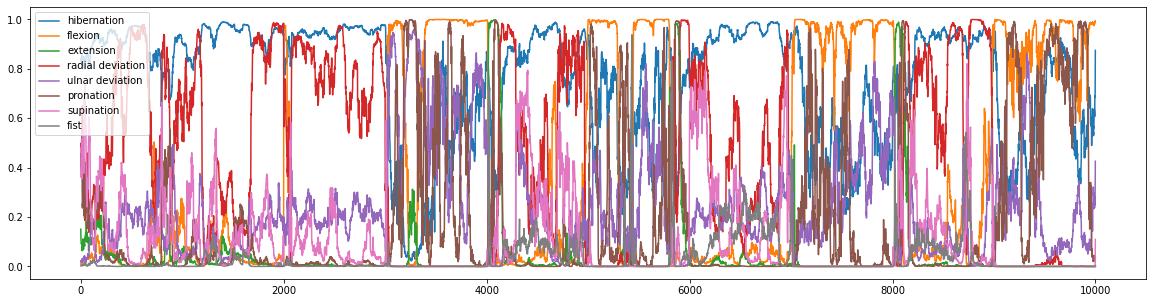

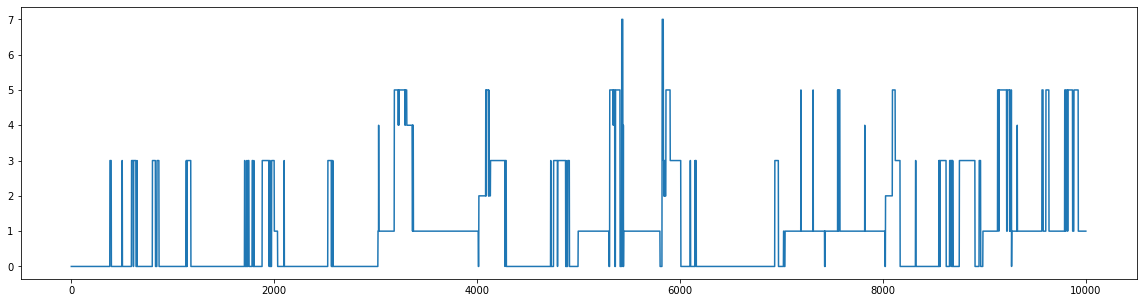

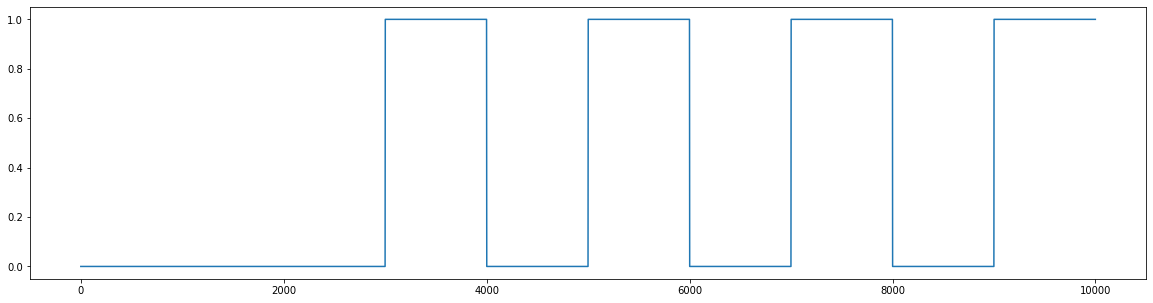

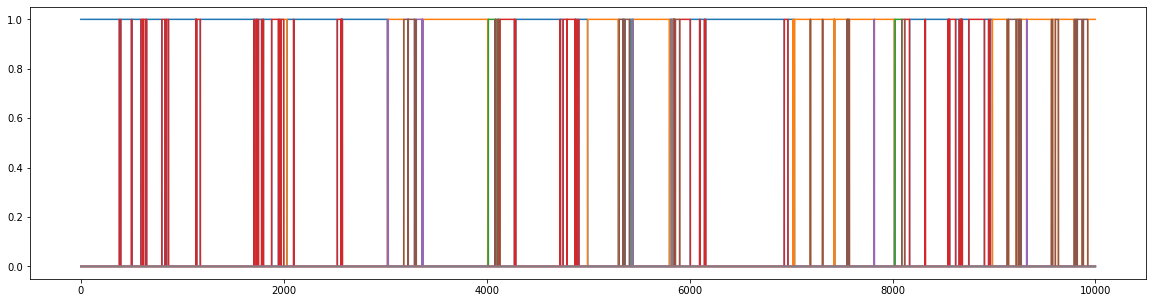

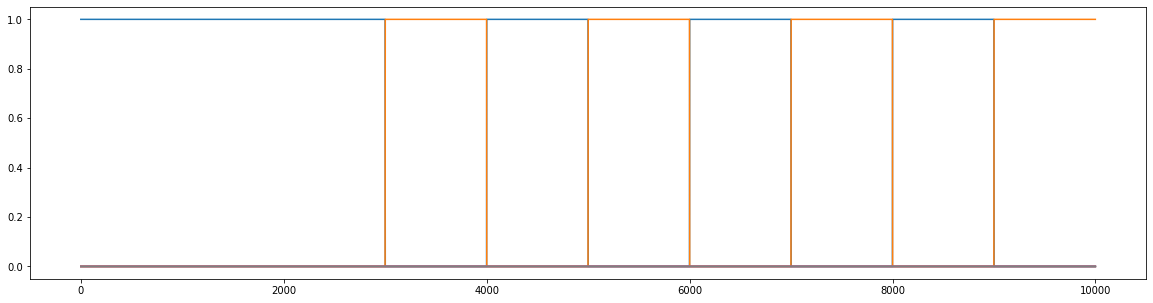

In [18]:
plt.figure()
plt.plot(predictions[10000:20000])
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(predicted_labels[10000:20000])
plt.figure()
plt.plot(test_labels[10000:20000])
plt.figure()
plt.plot(predicted_labels_onehot[10000:20000])
plt.figure()
plt.plot(test_labels_onehot[10000:20000])

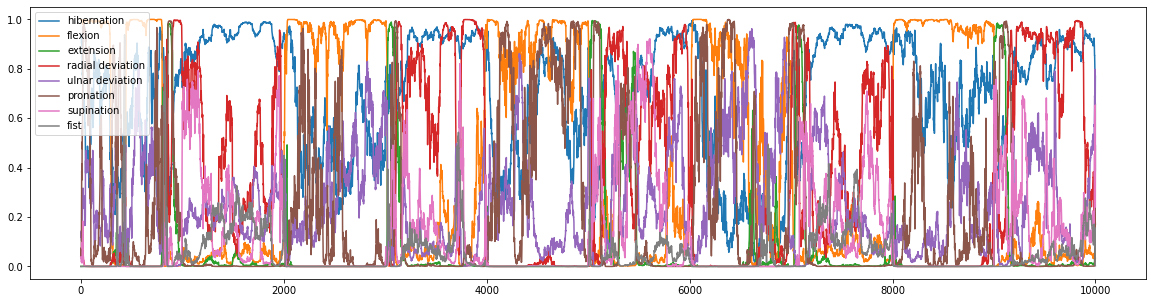

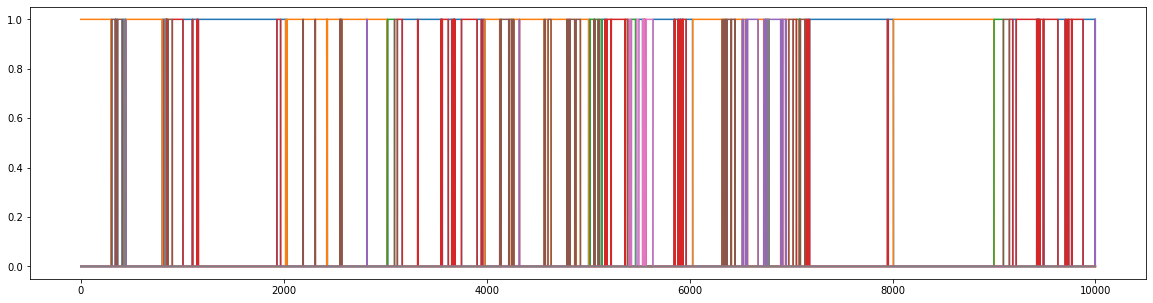

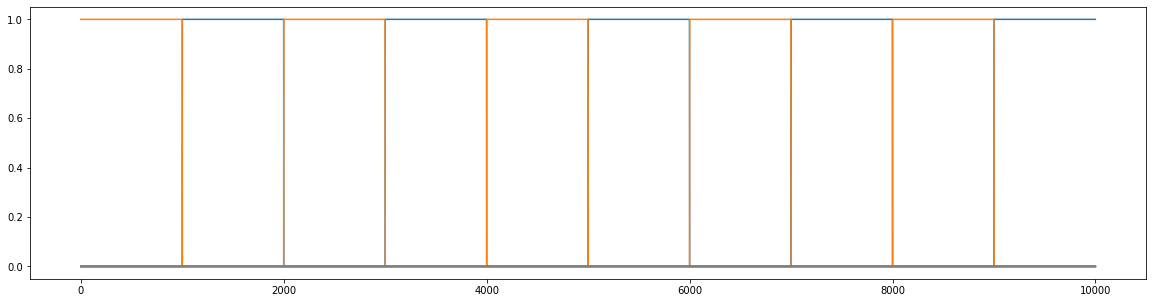

In [19]:
plt.figure()
plt.plot(predictions[15000:25000])
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(predicted_labels_onehot[15000:25000])
plt.figure()
plt.plot(test_labels_onehot[15000:25000])

In [20]:
training_analysis = model.predict(train)

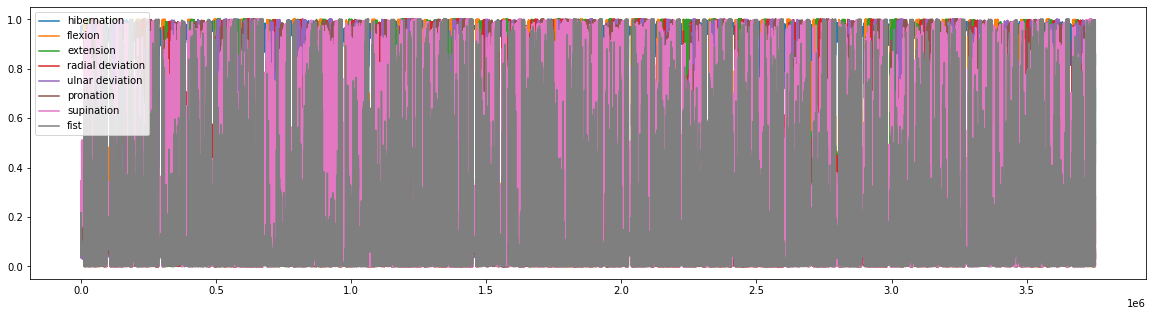

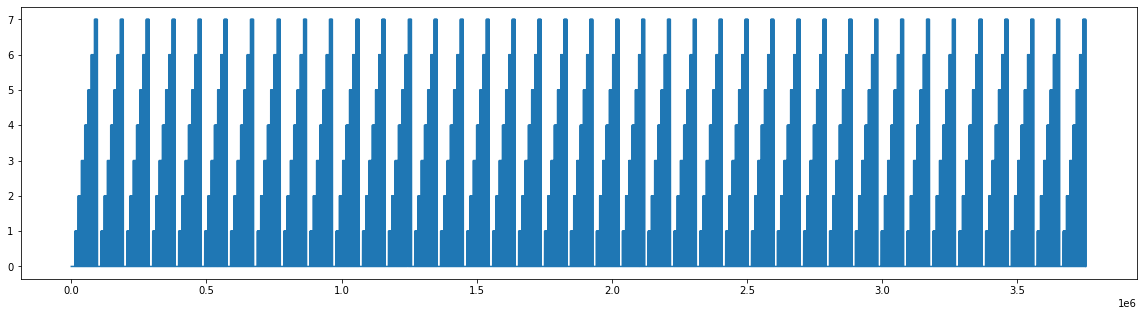

In [21]:
plt.figure()
plt.plot(training_analysis)
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(train_labels)

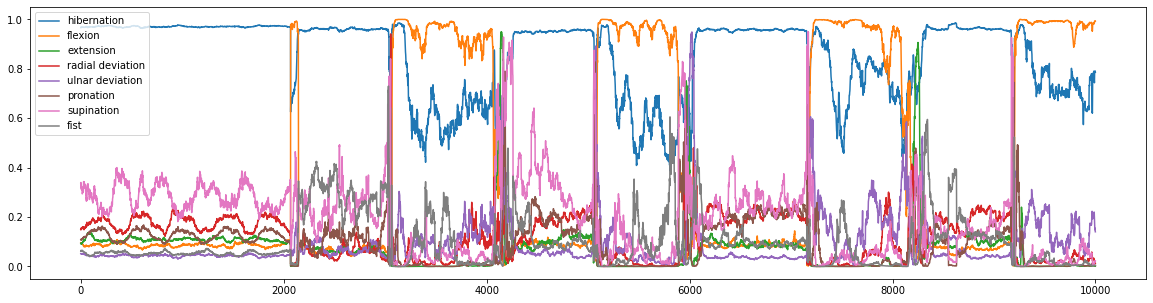

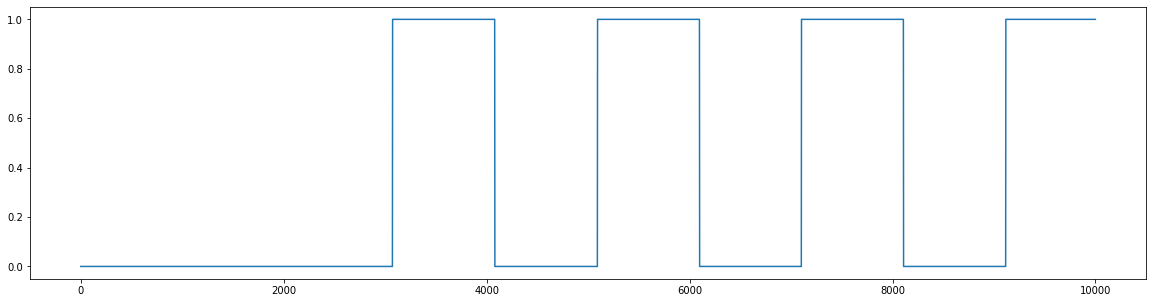

In [22]:
plt.figure()
plt.plot(training_analysis[10000:20000])
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(train_labels[10000:20000])